In [1]:
#https://pypi.python.org/pypi/Assimulo
#http://www.jmodelica.org/assimulo_home/tutorial_imp.html
#https://anaconda.org/search?q=assimulo

In [2]:
#conda install -c conda-forge assimulo

In [3]:
#http://www.jmodelica.org/assimulo_home/examples.html#
#http://www.jmodelica.org/assimulo_home/_modules/assimulo/examples/radau5dae_time_events.html#run_example

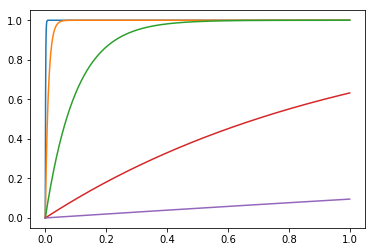

In [27]:
import numpy as np
t=np.linspace(0,1,1000)
def regexp(t,r):
    return 1.-np.exp(-1.*t/r)
for r in (.001,.01,.1,1,10):
    y=regexp(t,r)
    plt.plot(t,y)
plt.show()

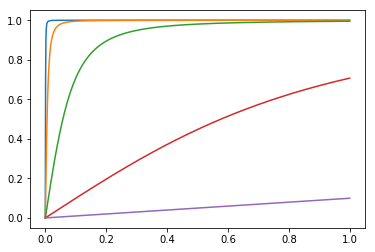

In [31]:
import numpy as np
t=np.linspace(0,1,1000)
def regsqrt(t,r):
    return (t/r)/np.sqrt((t/r)**2+1)
for r in (.001,.01,.1,1,10):
    y=regsqrt(t,r)
    plt.plot(t,y)

plt.show()

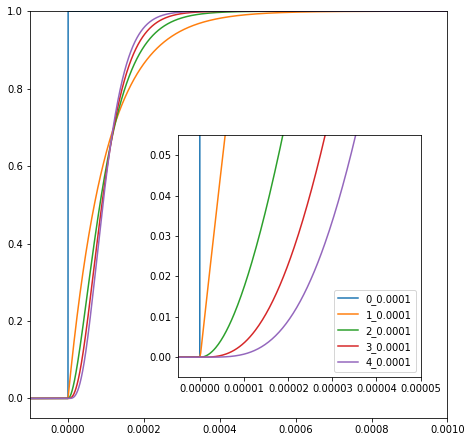

In [97]:
fig = plt.figure(figsize=(19/2.54,19/2.54))
from matplotlib import gridspec
gs=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs[0,0])
left, bottom, width, height = [0.4, 0.2, 0.45, 0.45]
ax1in=fig.add_axes([left, bottom, width, height])
import numpy as np
t=np.linspace(-.001,.001,10000)
def regntau(t,r,n):
    s=0.
    for i in range(n):
        s+= (1./np.math.factorial(i))*((n*(t/r))**i)
    y = 1.-(np.exp(-n*t/r)*s)
    y[t<0]=0. #expecting t as array
    #if t<0: y=0 #expecting t as scalar
    return y
    
for r in (.0001,):
    for n in (0,1,2,3,4):
        y=regntau(t,r,n)
        for ax in (ax1,ax1in):
            ax.plot(t,y,label=str(n)+"_"+str(r))

ax1.set_xlim(-.001/10,0.001)        
ax1.set_ylim(-.1/2,1.)   

ax1in.set_xlim(-0.0001/20,0.0001/2)        
ax1in.set_ylim(-.01/2,0.11/2)   
ax1in.legend(loc=0)
fig.canvas.draw()


#note when n=4 is departs with zero slope
#with r sufficiently small (.0001) it saturates before 0.0003 s

In [77]:
#CVode and IDA can use Assimulos method through the option ”external_event_detection”

import numpy as np

from assimulo.solvers import Radau5DAE, IDA
from assimulo.problem import Implicit_Problem

class supersatICEPolProblem(Implicit_Problem):
    def __init__(self, **kargs):
        Implicit_Problem.__init__(self, **kargs)
        self.name = 'supersatICE'
        self.swnuc = 0.
        self.tnuc = 0.
        self.regdn = 1e-7
        self.regq =1e1
        self.CpL=1.
        self.CpI=10.
        self.Tfreez=273.
        self.Tbath=230.
        self.Tnuc=250.
        self.DHIL=-500.
        
    #Define the residual
    def res(self,t,y,yd):
        #TRANSLATION
        nL, nI, hL, hI, HL, HI, Hsis, q, T = y
        dnL, dnI, dhL, dhI, dHL, dHI, dHsis, dq, dT = yd

        res_0 = (dnL)-(-dnI)                 #BALMASS
                #dnI->L=k*(Tsis-Teq)

        if (nL>=-.01 and nI>=-.01):
            res_1 = (dnL)-self.swnuc*(1.-np.exp(-1.*(t-self.tnuc)/self.regdn))*(1e-1*(y[8]-273.))  #MODELO DE TRANSFASE
        else:
            res_1 = (dnL)-(0.)
        pass
                #barHL=CpL(Tsis-Tref)
        res_2 = (y[2]) - ( 1.*(y[8]-273.15) )     #PROP ENERGIA-T
                #barHI=CpI(Tsis-Tref)
        res_3 = (y[3]) - ( 10.*(y[8]-273.15)-500. )     #PROP ENERGIA-T
                #HL=nLbarHL
        res_4 = (y[4])-(y[0]*y[2])     #PROP
                #HI=nIbarHI
        res_5 = (y[5])-(y[1]*y[3])     #PROP
                #Hsis=HL+HI
        res_6 = (y[6])-(y[4]+y[5])     #BALENERGIA
                #dHsis=q => (dH=dU+PdV, dU = q+w, w=PdV :. dH=q)
        res_7 = (yd[6])-(y[7])         #MODELO DE TRANSCAL1/2
                #q=k(Tsis-Tbath) .OR. q=0
        #res_8 =  (y[7])-(0.) #isolation
        res_8 =  (y[7])-(1.-np.exp(-1.*t/self.regq))*(1e0*(-y[8]+230.)) #MODELO DE TRANSCAL2/2
        return np.array([res_0,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8])
    
    def time_events(self, t,y,yd,sw):
        tnext = None
#         events = [5.0]
#         for ev in events:
#             if t < ev:
#                 tnext = ev
#                 break
#             else:
#                 tnext = None
        return tnext
        
    def state_events(self, t, y, yd, sw):
        """
        This is the function that keeps track of  events. When the sign
        of any of the functions changed, we have an event.
        """
        event_0 = y[8]-250.

        return np.array([event_0])
    
    def handle_event(self, solver, event_info):
        """
        Event handling. This functions is called when Assimulo finds an event as
        specified by the event functions.
        """
        state_info = event_info[0] #We are only interested in state events

        if state_info[0] != 0: #Check if the first event function has been triggered
            self.swnuc = 1. #turn growth on
            self.tnuc = solver.t
            #solver.sw[0] = not solver.sw[0] #Change event function OR NOT

def run_example():
    
    y0  = [1.0, #nL
           0., #nI
           1.*(298.-273.15), #hL
           10.*(298.-273.15)-500., #hI
           1.*1.*(298.-273.15), #HL
           0.*(10.*(298.-273.15)-500.), #HI
           1.*1.*(298.-273.15) + 0.*(10.*(298.-273.15)-500.), #Hsis
           0, #q
           298, #T
          ] #Initial states
    yd0 = [0., #dnL
           0., #dnI
           0., #dhl ~
           0., #dhI ~
           0., #dHL ~
           0., #dHI ~
           0., #dHsis
           0.,   #dq
           0., #dT
          ] #Initial state derivatives
    
    #Define an extended Assimulo problem
    imp_mod = supersatICEPolProblem(y0=y0,yd0=yd0)

    #Define an explicit solver
    imp_sim = IDA(imp_mod) #Create a Radau5 solver

    #Simulate
    t, y, yd = imp_sim.simulate(30.) #Simulate 8 seconds
    
    #Basic test
    x1 = y[:,0]
    return imp_mod, imp_sim

mod,sim = run_example()

Final Run Statistics: supersatICE 

 Number of steps                                 : 495
 Number of function evaluations                  : 796
 Number of Jacobian evaluations                  : 140
 Number of function eval. due to Jacobian eval.  : 1260
 Number of error test failures                   : 40
 Number of nonlinear iterations                  : 796
 Number of nonlinear convergence failures        : 15
 Number of state function evaluations            : 533
 Number of state events                          : 3

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 30.0 seconds.
Elapsed simulation time: 0.07186500000000251 seconds.


In [16]:
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

nsis=9
labels="nL,nI,hL,hI,HL,HI,Hsis,q,T".replace(" ","").split(",")
labesd=dict(zip(labels,range(nsis)))

print(labesd)
def ids(words):
    idi=[]
    for word in words.replace(" ","").split(","):
        idi+=[labesd[word]]
    return idi

{'nL': 0, 'nI': 1, 'hL': 2, 'hI': 3, 'HL': 4, 'HI': 5, 'Hsis': 6, 'q': 7, 'T': 8}


# problemas ao varia regn e regq
tem q ver isso aí

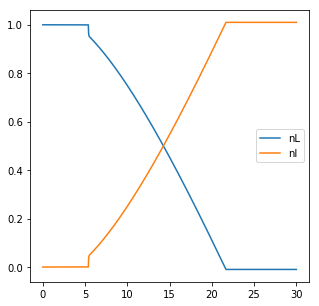

In [18]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
for k in ids("nL,nI"):
    yaxis=(sim.y_sol[i][k] for i in range(len(sim.y_sol)))
    ax.plot(sim.t_sol,np.fromiter(yaxis,dtype=np.float),label=labels[k])
ax.legend(loc=0)
fig.canvas.draw()

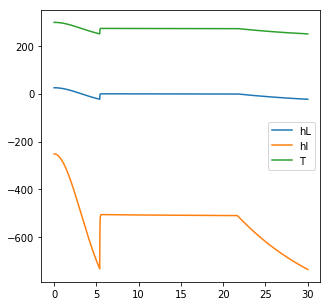

In [20]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
for k in ids("hL,hI,T"):
    yaxis=(sim.y_sol[i][k] for i in range(len(sim.y_sol)))
    ax.plot(sim.t_sol,np.fromiter(yaxis,dtype=np.float),label=labels[k])
ax.legend(loc=0)
fig.canvas.draw()

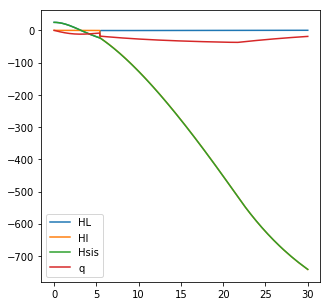

In [22]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
for k in ids("HL,HI,Hsis,q"):
    yaxis=(sim.y_sol[i][k] for i in range(len(sim.y_sol)))
    ax.plot(sim.t_sol,np.fromiter(yaxis,dtype=np.float),label=labels[k])
ax.legend(loc=0)
fig.canvas.draw()

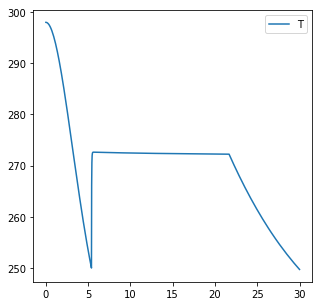

In [23]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
for k in ids("T"):
    yaxis=(sim.y_sol[i][k] for i in range(len(sim.y_sol)))
    ax.plot(sim.t_sol,np.fromiter(yaxis,dtype=np.float),label=labels[k])
ax.legend(loc=0)
fig.canvas.draw()